In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import AffineTransform, AbsTransform

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

from hbmep_paper.utils import simulate
from hbmep_paper.utils.constants import HBM, NHBM

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/experiments.toml")

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/experiments-debug/5/"


2023-08-07 13:35:43,102 - hbmep.config - INFO - Verifying configuration ...
2023-08-07 13:35:43,103 - hbmep.config - INFO - Success!


In [3]:
class HierarchicalBayesian(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesian, self).__init__(config=config)

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(
                    site.mu_a,
                    dist.TruncatedNormal(150, 50, low=0)
                )
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(50))

                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(0.1))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(0.05))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(5))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(mu_a, sigma_a, low=0)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(site.g_1, dist.HalfCauchy(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.HalfCauchy(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[feature0, subject]
            + jnp.maximum(
                0,
                -1
                + (H[feature0, subject] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[feature0, subject], v[feature0, subject]) - 1)
                    * jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject])),
                    1 / v[feature0, subject]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[feature0, subject] + g_2[feature0, subject] * (1 / mu)
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )



In [4]:
from hbmep_paper.model import Simulator


simulator = Simulator(config=config)

simulation_params = {
    "n_subject": 5,
    "n_feature0": 15,
    "n_repeats": 100,
    "downsample_rate": 1
}
df, posterior_samples_true = simulate(model=simulator, **simulation_params)

# ind = (df.participant == 3) & (df.compound_position == 0)
# df = df[ind].reset_index(drop=True).copy()

2023-08-07 13:35:43,164 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-08-07 13:35:43,164 - hbmep_paper.utils.utils - INFO - Simulating data ...


2023-08-07 13:35:46,223 - hbmep.utils.utils - INFO - func:predict took: 3.06 sec
2023-08-07 13:35:46,232 - hbmep.utils.utils - INFO - func:simulate took: 3.07 sec


In [5]:
model = HierarchicalBayesian(config=config)
df, encoder_dict = model.load(df=df)

obs = np.array(posterior_samples_true[site.obs])
df[model.response] = obs[1, ...]

2023-08-07 13:35:46,249 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-08-07 13:35:46,249 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/experiments-debug/5/
2023-08-07 13:35:46,250 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/experiments-debug/5/
2023-08-07 13:35:46,250 - hbmep.dataset.core - INFO - Processing data ...
2023-08-07 13:35:46,252 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [6]:
# model.plot(df=df, encoder_dict=encoder_dict)
# mcmc.warmup(model.rng_key, collect_warmup=True, extra_fields=("potential_energy",), *model._collect_regressors(df=df), *model._collect_response(df=df))


In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-08-07 13:35:46,287 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-08-07 16:50:55,968 - hbmep.utils.utils - INFO - func:run_inference took: 3 hr and 15 min


In [8]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   H[0,0,0]      4.16      0.12      4.15      3.97      4.34   1996.90      1.01
   H[0,1,0]      1.53      0.54      1.47      1.41      1.53     74.73      1.05
   H[0,2,0]      7.55      0.03      7.55      7.50      7.61     30.14      1.06
   H[0,3,0]      7.88      0.08      7.88      7.75      8.00    217.36      1.01
   H[0,4,0]      7.50      0.04      7.50      7.45      7.56     12.79      1.20
   H[1,0,0]      3.79      2.28      3.29      0.91      6.85    203.57      1.03
   H[1,1,0]      5.11      0.08      5.10      4.98      5.26     51.31      1.02
   H[1,2,0]      4.03      0.03      4.03      3.99      4.08   4064.09      1.01
   H[1,3,0]      7.11      4.71      6.69      0.32     12.91    718.34      1.01
   H[1,4,0]      2.06      0.04      2.07      1.99      2.13     11.23      1.12
   H[2,0,0]      0.50      0.01      0.50      0.49      0.51   2435.06      1.00
   H[2,1,0]    

In [ ]:
numpyro_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
az.summary(numpyro_data, var_names=[site.a, site.b, site.L, site.H, site.v])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0, 0]",128.718,1.813,125.309,131.895,0.018,0.013,10711.0,14505.0,1.00
"a[0, 1, 0]",218.203,0.703,216.880,219.469,0.010,0.007,4617.0,21486.0,1.01
"a[0, 2, 0]",264.656,0.309,264.062,265.193,0.002,0.001,22189.0,44993.0,1.00
"a[1, 0, 0]",136.545,0.734,135.261,137.952,0.008,0.006,7859.0,22961.0,1.00
"a[1, 1, 0]",187.668,0.062,187.553,187.782,0.000,0.000,38571.0,60223.0,1.00
"a[1, 2, 0]",247.241,0.104,247.046,247.431,0.000,0.000,71795.0,71961.0,1.00
"b[0, 0, 0]",0.018,0.012,0.004,0.040,0.000,0.000,1070.0,1472.0,1.02
"b[0, 1, 0]",0.024,0.010,0.009,0.042,0.000,0.000,439.0,2149.0,1.04
"b[0, 2, 0]",0.075,0.056,0.007,0.174,0.002,0.001,945.0,1254.0,1.02
"b[1, 0, 0]",0.086,0.031,0.047,0.141,0.001,0.001,1436.0,4478.0,1.02


In [ ]:
p = mcmc.get_samples(group_by_chain=True)

In [ ]:
a = np.array(p[site.a])
b = np.array(p[site.b])
g_1 = np.array(p[site.g_1])
g_2 = np.array(p[site.g_2])

In [ ]:
q = mcmc.get_samples(group_by_chain=True)
a_ = np.array(q["a"])
g_1_ = np.array(q[site.g_1])
g_2_ = np.array(q[site.g_2])

In [ ]:
potential = mcmc.get_extra_fields(group_by_chain=True)["potential_energy"]

<Axes: ylabel='Density'>

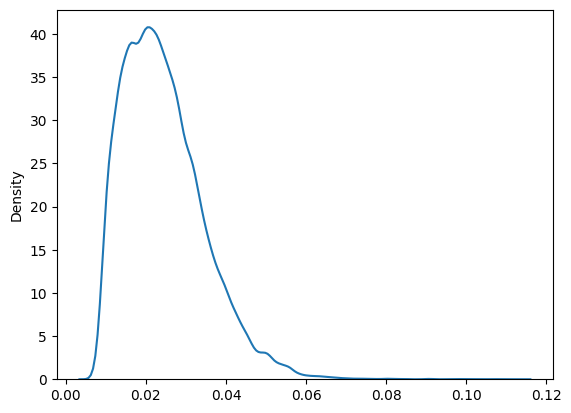

In [ ]:
sns.kdeplot(posterior_samples["b"][:, 0, 1, 0])

In [ ]:
posterior_samples["b"].shape

(120000, 2, 3, 1)

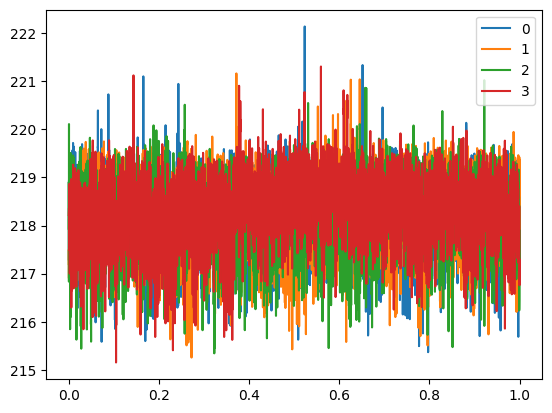

In [ ]:
import seaborn as sns

y0, y1, y2 = 0, 1, 0
x = np.linspace(0, 1, 6000)
var = a

for i in range(4):
    sns.lineplot(x=x, y=var[i, :, y0, y1, y2], label=f"{i}")

In [ ]:
posterior_samples["a"].shape

(120000, 2, 3, 1)

In [ ]:
t.participant += 1

In [ ]:
t.compound_position += 1

In [ ]:
t = df.copy()

In [9]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-07 16:53:29,531 - hbmep.model.baseline - INFO - Generating predictions ...
2023-08-07 16:54:33,989 - hbmep.utils.utils - INFO - func:predict took: 1 min and 4.45 sec
2023-08-07 16:54:34,232 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-08-07 16:54:59,510 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/experiments-debug/5/recruitment_curves.pdf
2023-08-07 16:54:59,510 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1 min and 29.98 sec


In [10]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-07 16:54:59,648 - hbmep.model.baseline - INFO - Generating predictions ...
2023-08-07 16:56:03,988 - hbmep.utils.utils - INFO - func:predict took: 1 min and 4.34 sec
2023-08-07 16:56:04,406 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-08-07 16:56:47,462 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/experiments-debug/5/posterior_predictive_check.pdf
2023-08-07 16:56:47,466 - hbmep.utils.utils - INFO - func:render_predictive_check took: 1 min and 47.82 sec
